# Multi-Class Classification on Synthetic Data with a Non-Deep LDA Head
This notebook keeps the same toy dataset as `Synthetic.ipynb`, but it trains a TrainableLDAHead directly on the 2D inputs (no deep encoder) and optimises it with `nn.NLLLoss`.


### Setup


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.lda import LDAHead, LDALoss, TrainableLDAHead, FullCovarianceLDAHead

### Generate Synthetic Dataset


In [2]:
# Three Gaussian clusters in 2D with shared covariance (matches plots/Sample.ipynb).
C, separation = 3, 1.7
NUM_CLASSES = C
LABEL_OFFSET = 1
pi = torch.full((C,), 1.0 / C)
base_mus = torch.tensor([[-2.0, -0.5],
                         [ 2.2,  0.2],
                         [-0.5,  2.3]], dtype=torch.float32)
mus = base_mus * separation
Sigma = torch.tensor([[1.0, 0.35],
                      [0.35, 1.1]], dtype=torch.float32)
chol = torch.linalg.cholesky(Sigma)

def sample_dataset(n_total, seed):
    gen = torch.Generator().manual_seed(seed)
    ys = torch.multinomial(pi, n_total, replacement=True, generator=gen)
    noise = torch.randn((n_total, 2), generator=gen)
    x = noise @ chol.T + mus[ys]
    y = ys + LABEL_OFFSET
    perm = torch.randperm(n_total, generator=gen)
    return x[perm], y[perm]

train_X, train_y = sample_dataset(20_000, seed=7)
test_X, test_y = sample_dataset(4_000, seed=137)

train_ds = TensorDataset(train_X, train_y)
test_ds = TensorDataset(test_X, test_y)

train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ld = DataLoader(test_ds, batch_size=1024, shuffle=False)

train_X[:5], train_y[:5]


(tensor([[-0.4112,  3.5449],
         [ 3.9778, -0.9086],
         [ 2.5725, -0.2544],
         [ 4.3941,  2.2189],
         [ 3.0573,  0.6371]]),
 tensor([3, 2, 2, 2, 2]))

### Model: identity encoder + trainable LDA head
We feed the raw 2D inputs through an identity encoder, so only the head parameters (class means, shared covariance, and priors) are learned.


In [3]:
class NonDeepLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.head = FullCovarianceLDAHead(C, D)

    def forward(self, x):
        return self.head(x)


### Training Utilities


In [4]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ok = tot = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device) - LABEL_OFFSET
        logits = model(X)
        ok += (logits.argmax(dim=1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

### Train Model


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

model = NonDeepLDA(C=NUM_CLASSES, D=2).to(device)
opt = torch.optim.Adam(model.parameters())
#loss_fn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss()
#loss_fn = LDALoss()

for epoch in range(1, 101):
    model.train()
    loss_sum = tot = correct = 0
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        y_zero = y - LABEL_OFFSET
        logits = model(X)
        loss = loss_fn(logits, y_zero)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            correct += (pred == y_zero).sum().item()
            tot += y.size(0)
            loss_sum += loss.item() * y.size(0)

    train_acc = correct / tot
    test_acc = evaluate(model, test_ld, device)
    print(f"[epoch {epoch:02d}] train loss={loss_sum/tot:.4f} acc={train_acc:.4f} | test acc={test_acc:.4f}")


device = cuda
[epoch 01] train loss=1.0722 acc=0.7686 | test acc=0.9303
[epoch 02] train loss=0.9953 acc=0.9331 | test acc=0.9393
[epoch 03] train loss=0.8692 acc=0.9385 | test acc=0.9295
[epoch 04] train loss=0.6899 acc=0.9293 | test acc=0.9243
[epoch 05] train loss=0.5011 acc=0.9376 | test acc=0.9497
[epoch 06] train loss=0.3577 acc=0.9659 | test acc=0.9780
[epoch 07] train loss=0.2602 acc=0.9841 | test acc=0.9902
[epoch 08] train loss=0.1902 acc=0.9906 | test acc=0.9925
[epoch 09] train loss=0.1391 acc=0.9917 | test acc=0.9935
[epoch 10] train loss=0.1041 acc=0.9920 | test acc=0.9932
[epoch 11] train loss=0.0810 acc=0.9925 | test acc=0.9935
[epoch 12] train loss=0.0656 acc=0.9924 | test acc=0.9935
[epoch 13] train loss=0.0549 acc=0.9923 | test acc=0.9938
[epoch 14] train loss=0.0472 acc=0.9926 | test acc=0.9940
[epoch 15] train loss=0.0414 acc=0.9927 | test acc=0.9942
[epoch 16] train loss=0.0370 acc=0.9929 | test acc=0.9942
[epoch 17] train loss=0.0336 acc=0.9929 | test acc=0.9940


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

model.eval()


NonDeepLDA(
  (head): FullCovarianceLDAHead()
)

### Collect a Small Random Subset of Embeddings


In [7]:
emb_list, y_list = [], []
max_points = int(len(train_ld.dataset) * 0.05)

with torch.no_grad():
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        z = X
        emb_list.append(z)
        y_list.append(y)
        if sum(t.shape[0] for t in emb_list) >= max_points:
            break

Z = torch.cat(emb_list, dim=0).cpu().numpy()[:max_points]
Y = torch.cat(y_list, dim=0).cpu().numpy()[:max_points]

### Inspect Learned Statistics


In [8]:
mu = model.head.mu.detach().cpu().numpy()  # (C, K, D) or (C*K, D)
#shared_cov = model.head.cov_diag.detach().cpu()
shared_cov = model.head.covariance_matrix().detach().cpu()
if shared_cov.dim() == 1:  # spherical/diagonal -> build matrix
    shared_cov = torch.diag(shared_cov)
shared_cov = shared_cov.numpy()
class_prior = torch.softmax(model.head.prior_logits, dim=0).detach().cpu().numpy()

### Visualise Embeddings


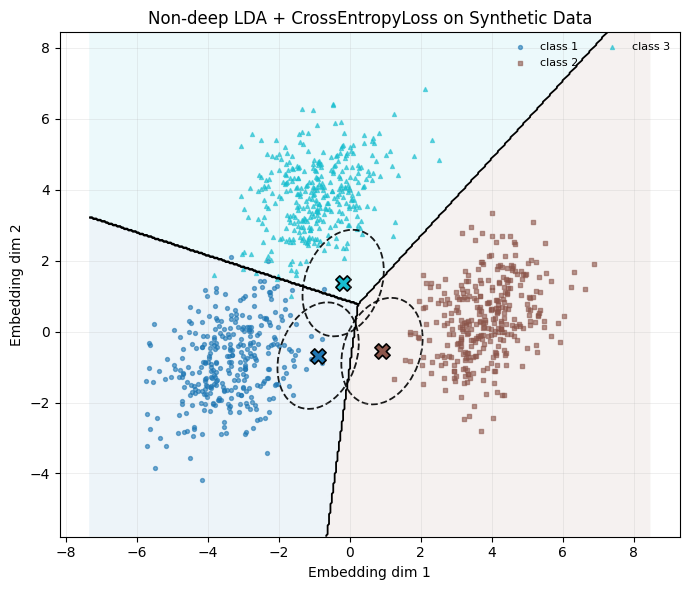

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
colors = plt.get_cmap('tab10', NUM_CLASSES)
markers = ['o', 's', '^', 'P', 'X', 'D', 'v']

classes = np.unique(Y)
centers = mu
if centers.ndim == 3:
    centers = centers[:, 0]
elif centers.ndim == 2 and centers.shape[0] != NUM_CLASSES:
    centers = centers.reshape(NUM_CLASSES, -1, centers.shape[-1])[:, 0]

pad = 1.6
xmin, xmax = Z[:, 0].min() - pad, Z[:, 0].max() + pad
ymin, ymax = Z[:, 1].min() - pad, Z[:, 1].max() + pad
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 400),
                     np.linspace(ymin, ymax, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Sigma_inv = np.linalg.inv(shared_cov)
w = (Sigma_inv @ centers.T).T
log_pi = np.log(class_prior + 1e-12)
b = -0.5 * np.sum(centers @ Sigma_inv * centers, axis=1) + log_pi
g = grid @ w.T + b
pred = g.argmax(axis=1).reshape(xx.shape)

region_cmap = plt.matplotlib.colors.ListedColormap([colors(i) for i in range(NUM_CLASSES)])
ax.contourf(xx, yy, pred, levels=np.arange(NUM_CLASSES + 1) - 0.5,
            cmap=region_cmap, alpha=0.08, antialiased=True)
ax.contour(xx, yy, pred, levels=np.arange(NUM_CLASSES) + 0.5,
           colors='k', linewidths=1.3, linestyles='-')


def cov_ellipse(mean, cov, k=2.15, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * k * np.sqrt(np.maximum(vals, 1e-12))
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

for idx, cls in enumerate(classes):
    mask = (Y == cls)
    marker = markers[idx % len(markers)]
    ax.scatter(Z[mask, 0], Z[mask, 1], s=8, alpha=0.6,
               c=[colors(idx)], marker=marker, label=f"class {int(cls)}")
    center = centers[int(cls - LABEL_OFFSET)]
    ax.scatter(center[0], center[1], s=120, marker='X',
               c=[colors(idx)], edgecolor='k', linewidths=1.2)
    ellipse = cov_ellipse(center, shared_cov, k=2.15,
                          edgecolor='k', facecolor='none',
                          linewidth=1.3, linestyle='--', alpha=0.9)
    ax.add_patch(ellipse)

ax.set_title('Non-deep LDA + CrossEntropyLoss on Synthetic Data')
ax.set_xlabel('Embedding dim 1')
ax.set_ylabel('Embedding dim 2')
ax.legend(fontsize=8, ncol=2, frameon=False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('equal')
ax.grid(True, linewidth=0.4, alpha=0.35)
plt.tight_layout()
plt.savefig('plots/Synthetic_NonDeepLDA_CELoss.png', dpi=600)
